In [1]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

!nvidia-smi

TF version: 2.17.1
Hub version: 0.16.1
Thu Apr 24 07:06:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------

In [2]:
import numpy as np

In [3]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2025-04-24 07:06:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-04-24 07:06:37 (16.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:

# Walk through 10 percent data directory and list number of files
walk_through_dir("/kaggle/input/agricultural-pests-dataset/train")
walk_through_dir("/kaggle/input/agricultural-pests-dataset/test")

There are 12 directories and 0 images in '/kaggle/input/agricultural-pests-dataset/train'.
There are 0 directories and 331 images in '/kaggle/input/agricultural-pests-dataset/train/beetle'.
There are 0 directories and 390 images in '/kaggle/input/agricultural-pests-dataset/train/grasshopper'.
There are 0 directories and 246 images in '/kaggle/input/agricultural-pests-dataset/train/earthworms'.
There are 0 directories and 400 images in '/kaggle/input/agricultural-pests-dataset/train/ants'.
There are 0 directories and 390 images in '/kaggle/input/agricultural-pests-dataset/train/earwig'.
There are 0 directories and 405 images in '/kaggle/input/agricultural-pests-dataset/train/snail'.
There are 0 directories and 329 images in '/kaggle/input/agricultural-pests-dataset/train/catterpillar'.
There are 0 directories and 394 images in '/kaggle/input/agricultural-pests-dataset/train/weevil'.
There are 0 directories and 405 images in '/kaggle/input/agricultural-pests-dataset/train/bees'.
There ar

In [5]:

# Create training and test directories
train_dir = "/kaggle/input/agricultural-pests-dataset/train/"
test_dir = "/kaggle/input/agricultural-pests-dataset/test/"

In [6]:
import os
import shutil

desired_classes = ['beetle', 'catterpillar', 'earwig', 'grasshopper', 'slug', 'snail', 'weevil']

filtered_train_dir = "/kaggle/working/filtered_train/"
filtered_test_dir = "/kaggle/working/filtered_test/"

In [7]:
os.makedirs(filtered_train_dir, exist_ok=True)
os.makedirs(filtered_test_dir, exist_ok=True)

for cls in desired_classes:
    shutil.copytree(os.path.join(train_dir, cls), os.path.join(filtered_train_dir, cls))
    shutil.copytree(os.path.join(test_dir, cls), os.path.join(filtered_test_dir, cls))

In [8]:

IMG_SIZE = (224, 224) # define image size
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=filtered_train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=filtered_test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 2555 files belonging to 7 classes.
Found 622 files belonging to 7 classes.


In [10]:
# How many images are there of each breed?
outputs=len(train_data.class_names)

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, regularizers

tf.keras.utils.enable_interactive_logging()
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = True
for layer in base_model.layers[:-10]:  
    layer.trainable = False

# Model architecture
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(7, kernel_regularizer=regularizers.l2(0.001))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5,restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.55, patience=4, min_lr=1e-6)


history = model.fit(
    train_data,
    epochs=150,
    validation_data=test_data,
    callbacks=[lr_scheduler,early_stopping]
)

# Evaluate
loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 289ms/step - accuracy: 0.4914 - loss: 1.5504 - val_accuracy: 0.8521 - val_loss: 0.6302 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8541 - loss: 0.6181 - val_accuracy: 0.8746 - val_loss: 0.4353 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8878 - loss: 0.4393 - val_accuracy: 0.8842 - val_loss: 0.3736 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9101 - loss: 0.3551 - val_accuracy: 0.8939 - val_loss: 0.3474 - learning_rate: 1.0000e-04
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9044 - loss: 0.3235 - val_accuracy: 0.8971 - val_loss: 0.3300 - learning_rate: 1.0000e-04
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9189 - loss: 0.2941 - val_accuracy: 0.8987 - val_loss: 0.3219 - learning_rate: 1.0000e-04
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy

In [26]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           8,967 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 7)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,109,575 (27.12 MB)

 Trainable params: 590,647 (2.25 MB)

 Non-trainable params: 5,337,632 (20.36 MB)

 Optimizer params: 1,181,296 (4.51 MB)

In [27]:
model.save("/kaggle/working/pest_classification.h5")

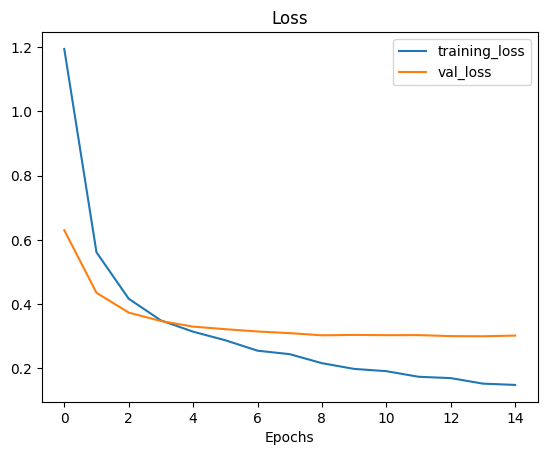

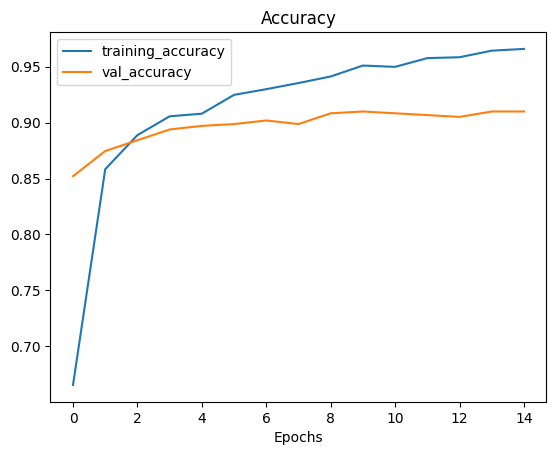

In [29]:

# Plot training and validation metrics
plot_loss_curves(history)

In [11]:
# Classes we're working with
classes = test_data.class_names

In [12]:
classes

['beetle', 'catterpillar', 'earwig', 'grasshopper', 'slug', 'snail', 'weevil']

In [13]:
model = tf.keras.models.load_model("/kaggle/input/pest-1/tensorflow2/default/1/pest_class3.h5")

In [14]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """

  img = tf.io.read_file(filename)
  
  img = tf.io.decode_image(img)
 
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [15]:
import matplotlib.pyplot as plt

In [16]:
class_names = classes

In [17]:
class_names

['beetle', 'catterpillar', 'earwig', 'grasshopper', 'slug', 'snail', 'weevil']

In [18]:
import tensorflow as tf
import numpy as np
import os
import time
import statistics
import logging

# Suppress TensorFlow logging
tf.keras.utils.disable_interactive_logging()

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Load the pre-trained model
try:
    model = tf.keras.models.load_model('/kaggle/input/pest-2/tensorflow2/default/1/pest_classification2.h5')
    logging.info("Model loaded successfully")
except Exception as e:
    logging.error(f"Failed to load model: {str(e)}")
    exit(1)

class_names = ['beetle', 'catterpillar', 'earwig', 'grasshopper', 'slug', 'snail', 'weevil']

# Function to load and prepare the image
def load_and_prep_image(filename, img_shape=224, scale=True):
    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        return img / 255.0
    else:
        return img

# Function to measure inference
def measure_inference(filename):
    img = load_and_prep_image(filename, scale=False)
    input_tensor = tf.expand_dims(img, axis=0)
    pred_prob = model.predict(input_tensor, verbose=0)
    return pred_prob

# Directory with test images
test_dir = "/kaggle/working/filtered_test"

# Expected subfolders
subfolders = ['beetle', 'catterpillar', 'earwig', 'grasshopper', 'slug', 'snail', 'weevil']

# Collect image paths from subfolders
image_paths = []
for subfolder in subfolders:
    subfolder_path = os.path.join(test_dir, subfolder)
    if not os.path.exists(subfolder_path):
        logging.warning(f"Subfolder {subfolder} does not exist")
        continue
    for fname in os.listdir(subfolder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(subfolder_path, fname))

if not image_paths:
    logging.error(f"No images found in subfolders of {test_dir}")
    print(f"No images found in subfolders of {test_dir}")
    exit(1)

# Measure latency for each image
latencies = []
num_iterations = len(image_paths)  # Process each image once

# Warm-up run (first image)
try:
    _ = measure_inference(image_paths[0])
    logging.info("Warm-up run completed")
except Exception as e:
    logging.error(f"Warm-up failed: {str(e)}")
    exit(1)

# Measure latency
for i, img_path in enumerate(image_paths):
    try:
        start_time = time.time()
        pred_prob = measure_inference(img_path)
        end_time = time.time()
        
        latency = end_time - start_time
        latencies.append(latency)
        
        logging.info(f"Image {i+1}/{num_iterations}: {os.path.basename(img_path)}, Latency: {latency:.2f} s")
    except Exception as e:
        logging.error(f"Failed to process {img_path}: {str(e)}")

# Calculate and report results
if latencies:
    avg_latency = statistics.mean(latencies)
    std_latency = statistics.stdev(latencies) if len(latencies) > 1 else 0
    iterations_per_sec = 1 / avg_latency if avg_latency > 0 else 0
    
    logging.info(f"Processed {len(latencies)} images")
    logging.info(f"Average latency: {avg_latency*1000:.2f} ms")
    logging.info(f"Standard deviation: {std_latency*1000:.2f} ms")
    logging.info(f"Images per second: {iterations_per_sec:.2f}")
    print(f"Processed {len(latencies)} images")
    print(f"Average latency: {avg_latency:.2f} s")
    print(f"Images per second: {iterations_per_sec:.2f}")
else:
    logging.error("No images processed successfully")
    print("No images processed successfully")

Processed 622 images
Average latency: 0.06 s
Images per second: 17.81


In [19]:
!ls

            

filtered_test  filtered_train  helper_functions.py  __pycache__


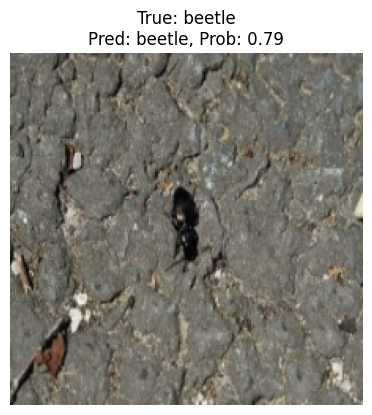

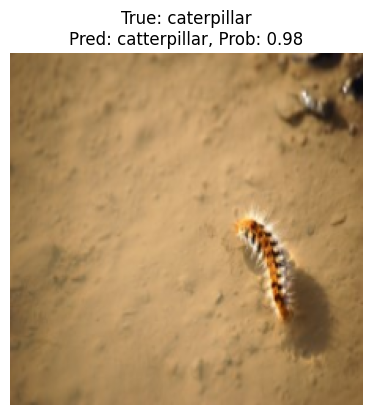

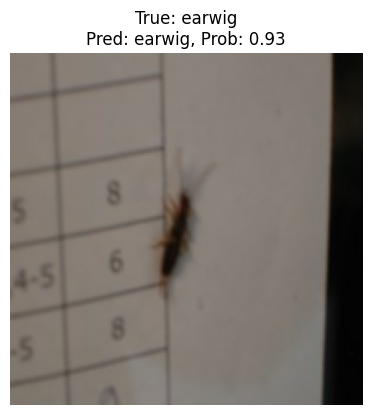

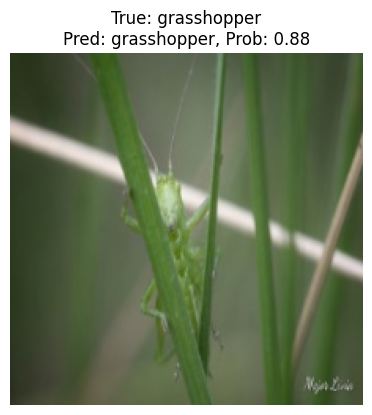

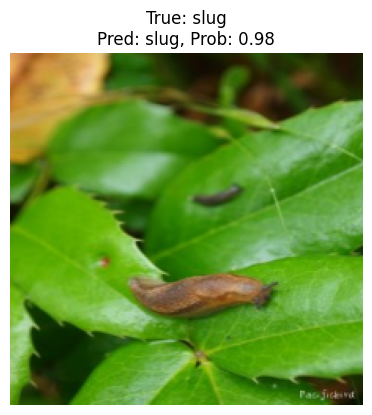

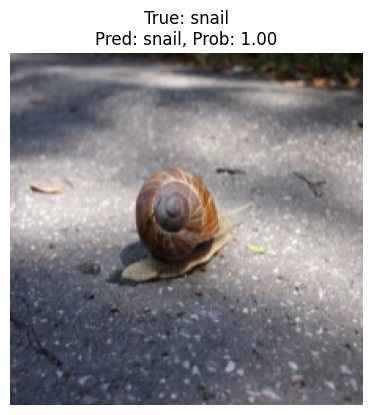

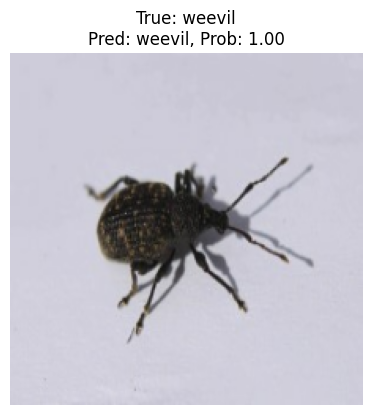

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Suppress TensorFlow progress bar and logging
tf.keras.utils.disable_interactive_logging()




# Dictionary of image paths
image_paths = {
    'beetle':'/kaggle/input/agricultural-pests-dataset/test/beetle/beetle (138).jpg',
    'caterpillar': '/kaggle/input/agricultural-pests-dataset/test/catterpillar/catterpillar (18).jpg',
    'earwig': '/kaggle/input/agricultural-pests-dataset/test/earwig/earwig (27).jpg',
    'grasshopper': '/kaggle/input/agricultural-pests-dataset/test/grasshopper/grasshopper (135).jpg',
    'slug': '/kaggle/input/agricultural-pests-dataset/test/slug/slug (177).jpg',
    'snail': '/kaggle/input/agricultural-pests-dataset/test/snail/snail (409).jpg',
    'weevil': '/kaggle/input/agricultural-pests-dataset/test/weevil/Weevil (195).jpg',
}

# Assuming load_and_prep_image is defined elsewhere (e.g., loading and preprocessing the image)
# Iterate through images
for label, path in image_paths.items():
    # Load and preprocess the image
    img = load_and_prep_image(path, scale=False)  # Replace with your actual preprocessing function
    
    # Predict the class probabilities
    pred_prob = model.predict(tf.expand_dims(img, axis=0), verbose=0)
    pred_class_idx = pred_prob.argmax()
    pred_class = class_names[pred_class_idx]
    pred_confidence = pred_prob.max()
    
    
    
    # Plot the original image and the saliency map
    plt.figure(figsize=(10, 5))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img / 255.0)  # Normalize image for display
    plt.title(f"True: {label}\nPred: {pred_class}, Prob: {pred_confidence:.2f}")
    plt.axis('off')
    
  
    # Show the plot
    plt.show()

Evaluating model on test dataset...

Classification Report:
              precision    recall  f1-score   support

      beetle       0.91      0.85      0.88        85
catterpillar       0.92      0.82      0.87       105
      earwig       0.88      0.86      0.87        76
 grasshopper       0.84      0.96      0.90        95
        slug       0.93      0.95      0.94        75
       snail       0.97      1.00      0.98        95
      weevil       0.95      0.98      0.96        91

    accuracy                           0.91       622
   macro avg       0.92      0.91      0.91       622
weighted avg       0.92      0.91      0.91       622



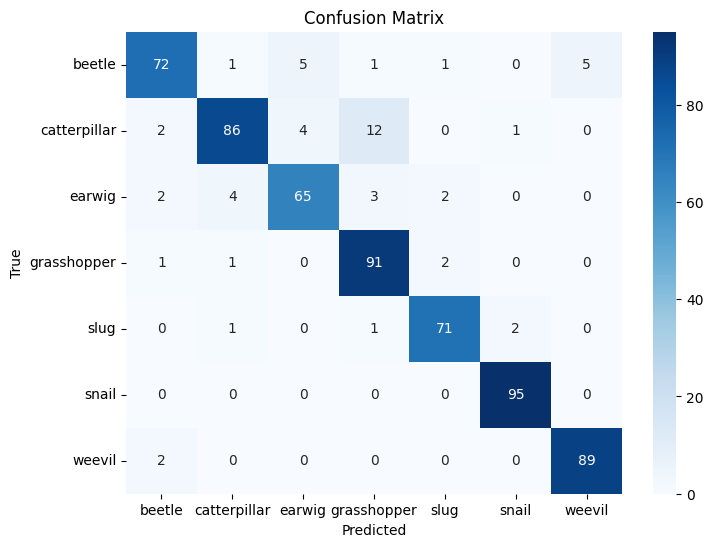


Test Metrics:
Accuracy: 0.9148
Precision: 0.9159
Recall: 0.9148
F1-Score: 0.9140


In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import os

# Suppress TensorFlow progress bar and logging
tf.keras.utils.disable_interactive_logging()



# Dictionary of image paths (for visualization, as in your original code)
image_paths = {
    'beetle': '/kaggle/input/agricultural-pests-dataset/test/beetle/beetle (138).jpg',
    'caterpillar': '/kaggle/input/agricultural-pests-dataset/test/catterpillar/catterpillar (18).jpg',
    'earwig': '/kaggle/input/agricultural-pests-dataset/test/earwig/earwig (27).jpg',
    'grasshopper': '/kaggle/input/agricultural-pests-dataset/test/grasshopper/grasshopper (135).jpg',
    'slug': '/kaggle/input/agricultural-pests-dataset/test/slug/slug (177).jpg',
    'snail': '/kaggle/input/agricultural-pests-dataset/test/snail/snail (409).jpg',
    'weevil': '/kaggle/input/agricultural-pests-dataset/test/weevil/Weevil (195).jpg',
}

# Function to load and preprocess images (replace with your actual implementation if different)
def load_and_prep_image(path, scale=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])  # EfficientNetV2B0 expects 224x224
    if not scale:
        img = img / 255.0  # Normalize to [0, 1]
    return img

# Load test dataset
test_data_dir = '/kaggle/working/filtered_test/'
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False  # Keep shuffle off for consistent evaluation
)

# Evaluate the model on the test dataset
def evaluate_model(model, test_dataset):
    # Initialize lists to store predictions and true labels
    y_true = []
    y_pred = []
    
    # Iterate through the test dataset
    for images, labels in test_dataset:
        # Predict
        preds = model.predict(images, verbose=0)
        # Convert predictions and labels to class indices
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
    
    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Compute metrics
    accuracy = np.mean(y_true == y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Compute and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return accuracy, precision, recall, f1

# Run evaluation
print("Evaluating model on test dataset...")
accuracy, precision, recall, f1 = evaluate_model(model, test_dataset)
print(f"\nTest Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



In [21]:
model.summary()